In [16]:
import numpy
import matplotlib.pyplot as plt
%matplotlib inline
import math
import sys
import h5py

from numpy import loadtxt
from os import listdir

In [566]:
from __future__ import division, print_function

import illustris_api as ia

import matplotlib.pyplot as pyplot

# Illustris API Configuration
ia.set_apikey('4e2c93455bbc8e991a91a61ef5e11daa')

h = 0.704 # Apparently

# 0.0097 to 0.00971 has nearly 40,000 subhalos??
# ended here

snap = 120
z = 0.2
# lower = 0.0755
# upper = 0.0756

lower = 0.0199
upper = 0.02

def test_plot(fname):
    f = h5py.File(fname,'r')
    x = f['PartType0']['Coordinates'][:,0]
    z = f['PartType0']['Coordinates'][:,1]
    dens = numpy.log10(f['PartType0']['Masses'][:])
    import matplotlib.pyplot as pyplot
    pyplot.figure()
    pyplot.hist2d(z,x,weights=dens,bins=[150,100])
    pyplot.show()


files = None
#files = ['cutout_41094.hdf5.orig'] # uncomment and set this to suppress to downloading

if files is None: 

    halo_data_prelim = ia.obtain_halos_by_mass(lower, upper, snap)

    c = halo_data_prelim['count']
    if ia.DEBUG: print(c)

    halo_ids, halo_data = ia.obtain_subhalos_data(halo_data_prelim, snap, z)

    halo_ids, halo_data = ia.filter_haloids(halo_ids, halo_data, filters=[ia.filter_non_zero_mass, ia.filter_star_mass, ia.filter_fluid_mass], args=[None, {'lower': 0.0001, 'upper': 0.0995}, {'lower': 0.00001, 'upper': 0.01}])

    if ia.DEBUG: print(halo_ids[:])

    ia.store_metadata(halo_data)
    
    # This is an example of how to unpickle, not a real bit of code :-)
    # You probably don't want to uncomment this!S
    #new_halos = ia.load_metadata(['data_9.pickle', 'data_66085.pickle', 'data_183685.pickle'])
    #print(len(new_halos))

    files = ia.obtain_cutouts(halo_data, gascols=['Coordinates', 'Density', 'GFM_Metallicity', 'Masses', 'SmoothingLength', 'Velocities'], starcols=['Coordinates', 'Masses', 'Velocities','GFM_Metallicity'], count=None)

    Ldata = []
    ia.detilt_files(files, halo_data, L_outputs=Ldata)
    if ia.DEBUG: print(Ldata)

ia.process_cutouts_for_splash(files)

Setting API Key to 4e2c93455bbc8e991a91a61ef5e11daa
 Obtaining subhalos in mass range 0.0199 to 0.02 at snapshot 120.000000
   181 subhalos will be obtained in 100-element chunks
 Obtaining metadata for 181 subhalos
     0 % done
     10 % done
     20 % done
     30 % done
     40 % done
     50 % done
     60 % done
     70 % done
     80 % done
     90 % done
     100 % done
Initial idn set = 181
181
Applying filter filter_non_zero_mass
 0 eliminated due to less than epsilon mass
 1 eliminated due to less than epsilon mass
 2 eliminated due to less than epsilon mass
 3 eliminated due to less than epsilon mass
 4 eliminated due to less than epsilon mass
 6 eliminated due to less than epsilon mass
 7 eliminated due to less than epsilon mass
 8 eliminated due to less than epsilon mass
 9 eliminated due to less than epsilon mass
 10 eliminated due to less than epsilon mass
 11 eliminated due to less than epsilon mass
 12 eliminated due to less than epsilon mass
 13 eliminated due to les

Limiting angular momentum calculation to r < 0
 "splashifying" cutout_559535.hdf5, output will be saved to cutout_559535_splash.hdf5


/Users/sandyspicer/Desktop/RIT/Illustris-3/groups_135/illustris_api/dwarf/z=0.2/illustris_api.py:1037: RuntimeWarning: invalid value encountered in true_divide
  Lhat = totL/modL # this is the direction the total angular momentum vector points


In [551]:
stellar_mass = []
fluid_mass = []
virial_mass = []


for h in halo_data:
    stellar_mass.append(h['mass_stars'])
    fluid_mass.append(h['mass_gas'])
    
    
for i in range(0,len(halo_data_prelim['results'])):
    for j in range(0,len(halo_ids)):
        if halo_data_prelim['results'][i]['id'] == halo_ids[j]:
            virial_mass.append(halo_data_prelim['results'][i]['mass_log_msun'])
            
print(halo_ids)    
print(stellar_mass)
print(fluid_mass)
print(virial_mass)


[580201, 645306, 676750]
[0.000268, 0.000228, 0.000141]
[0.004676, 0.003189, 0.005512]
[8.442328302586514, 8.447576437436807, 8.448236259019064]


In [552]:
def get_HI(halo_ids):
    f = []
    HI = []
    mean = []
    for i in halo_ids:
        f = h5py.File('/Users/sandyspicer/Desktop/RIT/Illustris-3/groups_135/illustris_api/dwarf/z=0.2/cutout_'+str(i)+'.hdf5', 'r')
        HI.append(f['PartType0']['NeutralHydrogenAbundance'][:])
        
    for j in range(0,len(HI)):
        mean.append(numpy.ndarray.mean(HI[j]))

    return mean

In [553]:
HI_abundance = get_HI(halo_ids)
print(HI_abundance)
print(halo_ids)

[0.93074614, 0.89809674, 0.9473702]
[580201, 645306, 676750]


In [554]:
def get_HI_mass(HI_abundance,fluid_mass):
    
    m_p = 1.6726219e-27 * (1 / 1.989e30) * (1 / 10e10) * 0.704 # units of 10^10 Msol/h
    number_density = []
    MHI = []
    
    for m in fluid_mass:
        n = m / m_p # take fluid mass and divide by mass of proton to get number density of Hydrogen
        number_density.append(n)
        
    for i in range(0,len(HI_abundance)):
        
        n_HI = HI_abundance[i] * number_density[i]
        mhi = n_HI * m_p
        MHI.append(mhi)
        
    return MHI

In [555]:
HI = get_HI_mass(HI_abundance,fluid_mass)
print(HI)
print(fluid_mass)
print(halo_ids)

[0.004352168941736221, 0.002864030504643917, 0.005221904385566711]
[0.004676, 0.003189, 0.005512]
[580201, 645306, 676750]


In [556]:
# Only appends Lhat vectors that have values. Removes nan values
Lhat = []
entry = []
for i in range(0,len(Ldata)):
    Lhat.append(Ldata[i][2])
    angm = Ldata[i][2]
    if abs(angm[0])>0:
        #Lhat.append(Ldata[i][2])
        entry.append(i)
        
print(Lhat)

[array([ 0.7490334 ,  0.6563501 , -0.09029689], dtype=float32), array([-0.5206469 , -0.8426168 ,  0.13756382], dtype=float32), array([nan, nan, nan], dtype=float32)]


In [557]:
def get_coordinates(fname):
    f = h5py.File(fname,'r')
    x = f['PartType0']['Coordinates'][:,0]
    z = f['PartType0']['Coordinates'][:,1]
    y = f['PartType0']['Coordinates'][:,2]
    
    return x,y,z

In [558]:
def metallicity_plot(fname,Lhat):
    f = h5py.File(fname,'r')
    x = f['PartType0']['Coordinates'][:,0]
    z = f['PartType0']['Coordinates'][:,1]
    y = f['PartType0']['Coordinates'][:,2]
    
    met = f['PartType0']['GFM_Metallicity'][:]/0.0127
    
    import matplotlib as mpl
    import matplotlib.pyplot as plt

    
    plt.figure()
    plt.hist2d(z,y,weights=met,bins=[200,100],norm=mpl.colors.LogNorm())
    plt.colorbar()
    #plt.clim(0.1, 1)
    plt.title(str(fname))
    plt.show()
    print('YZ-plane')

    plt.figure()
    plt.hist2d(x,y,weights=met,bins=[200,100],norm=mpl.colors.LogNorm())
    plt.colorbar()
    #plt.clim(0.1, 1)
    plt.title(str(fname))
    plt.show()
    print('XY-plane')

    plt.figure()
    plt.hist2d(z,x,weights=met,bins=[200,100],norm=mpl.colors.LogNorm())
    plt.colorbar()
    #plt.clim(0.1, 1)
    plt.title(str(fname))
    plt.show()
    print('XZ-plane')
    
    print("------------------------Best cutout--------------------------")
    

    if abs(Lhat[0]) >= abs(Lhat[1]) and abs(Lhat[0]) >= abs(Lhat[2]):
        plt.figure()
        plt.hist2d(z,y,weights=met,bins=[200,100],norm=mpl.colors.LogNorm())
        plt.colorbar()
        #plt.clim(0.1, 1)
        plt.title(str(fname))
        plt.show()
        print('YZ-plane')

    if abs(Lhat[1]) >= abs(Lhat[0]) and abs(Lhat[1]) >= abs(Lhat[2]):
        plt.figure()
        plt.hist2d(x,y,weights=met,bins=[200,100],norm=mpl.colors.LogNorm())
        plt.colorbar()
        #plt.clim(0.1, 1)
        plt.title(str(fname))
        plt.show()
        print('XY-plane')

    if abs(Lhat[2]) >= abs(Lhat[0]) and abs(Lhat[2]) >= abs(Lhat[1]):
        plt.figure()
        plt.hist2d(z,x,weights=met,bins=[200,100],norm=mpl.colors.LogNorm())
        plt.colorbar()
        #plt.clim(0.1, 1)
        plt.title(str(fname))
        plt.show()
        print('XZ-plane')
        
        
    print(min(met),max(met))
    print(Lhat)
    print("------------------------Best cutout--------------------------")

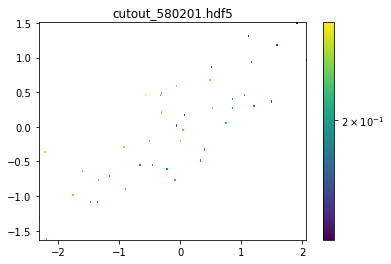

YZ-plane


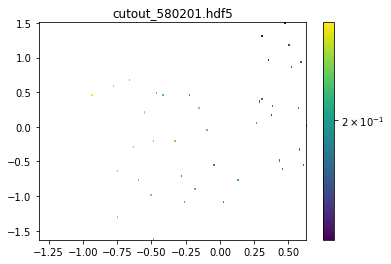

XY-plane


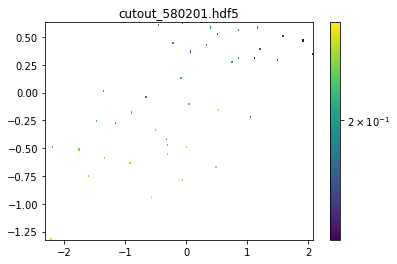

XZ-plane
------------------------Best cutout--------------------------


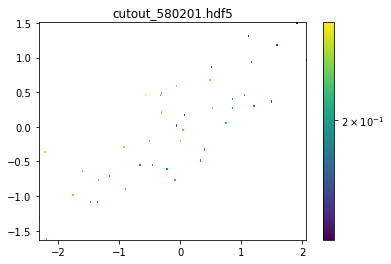

YZ-plane
0.12190583 0.29932392
[ 0.7490334   0.6563501  -0.09029689]
------------------------Best cutout--------------------------


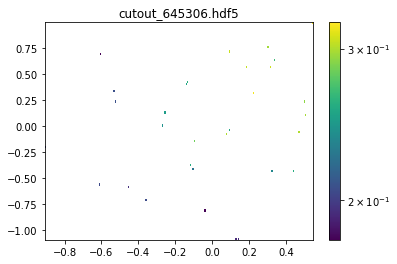

YZ-plane


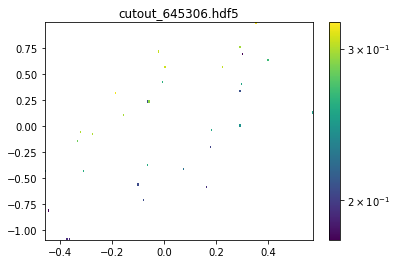

XY-plane


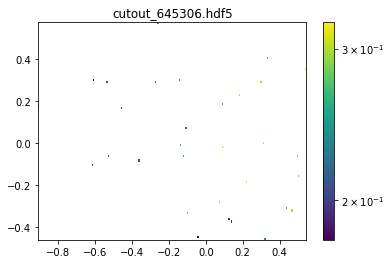

XZ-plane
------------------------Best cutout--------------------------


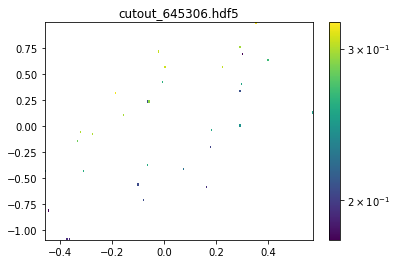

XY-plane
0.17966036 0.32177722
[-0.5206469  -0.8426168   0.13756382]
------------------------Best cutout--------------------------


In [559]:
for i in entry:
    metallicity_plot('cutout_'+str(halo_ids[i])+'.hdf5',Lhat[i]) 

In [560]:
def get_metallicity(halo_ids):
    f = []
    Z = []
    mean = []
    for i in halo_ids:
        f = h5py.File('/Users/sandyspicer/Desktop/RIT/Illustris-3/groups_135/illustris_api/dwarf/z=0.2/cutout_'+str(i)+'.hdf5', 'r')
        Z.append(f['PartType0']['GFM_Metallicity'][:]/0.0127)
    for j in range(0,len(Z)):
        mean.append(numpy.ndarray.mean(Z[j]))

    return mean

In [561]:
def get_SFR(halo_ids):
    f = []
    SFR = []
    mean = []
    total = []
    for i in halo_ids:
        f = h5py.File('/Users/sandyspicer/Desktop/RIT/Illustris-3/groups_135/illustris_api/dwarf/z=0.2/cutout_'+str(i)+'.hdf5', 'r')
        SFR.append(f['PartType0']['StarFormationRate'][:])
    for j in range(0,len(SFR)):
        mean.append(numpy.ndarray.mean(SFR[j]))
    for k in range(0,len(SFR)):
        total.append(numpy.ndarray.sum(SFR[k]))

    return total

In [562]:
metallicity = get_metallicity(halo_ids)
print(metallicity)
#print(numpy.mean(metallicity))

starformation = get_SFR(halo_ids)
print(starformation)

[0.21056917, 0.2514321, 0.026867567]
[0.0025179912, 0.0033337642, 0.001711208]


In [563]:
with open("master_dwarf_z=0.2.txt", "a") as myfile:
    for i in range(0,len(halo_ids)):
        ids = halo_ids[i],stellar_mass[i],fluid_mass[i],virial_mass[i],HI_abundance[i], HI[i], [Lhat[i][0],Lhat[i][1],Lhat[i][2]], metallicity[i], starformation[i]
        myfile.write(str(ids)+'\n')

In [ ]:
def get_metallicity(halo_ids):
    f = []
    Z = []
    mean = []
    for i in halo_ids:
        f = h5py.File('/Users/sandyspicer/Desktop/RIT/Illustris-3/groups_135/illustris_api/dwarf/cutout_'+str(i)+'.hdf5', 'r')
        Z.append(f['PartType0']['GFM_Metallicity'][:]/0.0127)
    for j in range(0,len(Z)):
        mean.append(numpy.ndarray.mean(Z[j]))

    return mean

In [ ]:
def get_SFR(halo_ids):
    f = []
    SFR = []
    mean = []
    total = []
    for i in halo_ids:
        f = h5py.File('/Users/sandyspicer/Desktop/RIT/Illustris-3/groups_135/illustris_api/dwarf/cutout_'+str(i)+'.hdf5', 'r')
        SFR.append(f['PartType0']['StarFormationRate'][:])
    for j in range(0,len(SFR)):
        mean.append(numpy.ndarray.mean(SFR[j]))
    for k in range(0,len(SFR)):
        total.append(numpy.ndarray.sum(SFR[k]))

    return total

In [169]:
metallicity = get_metallicity(halo_ids)
print(metallicity)

starformation = get_SFR(halo_ids)
print(starformation)

converted_stellar_mass = []
for i in stellar_mass:
    x = i*1e10*0.704
    converted_stellar_mass.append(x)


[0.69150203, 0.23054741]
[0.025253218, 0.0007354362]


In [168]:
def readData(filename):
    #Reads data from a file output from the 'writeData' function into an array that (hopefully) is of the same format as the original
    file = open(filename,'r')
    #Initializes an empty list that will become the returned all_data array
    data = []
    #Two boolean flags for handling the 'L_data' sublist (theres easier ways to do this [tracking variables])
    flag1 = False
    flag2 = False
    #Initializes an empty sublist for L_data, to prevent reference-before-assignment errors
    L_list = []
    #Tracks current line number, only needed for the header (element 0)
    track2 = 0
    for line in file:
        #Initializes the empty sublist (becomes primary array element)
        subList = []
        #uses the built in split function to seperate a line of text into a list of strings, based on whitespace
        els = str.split(line)
        #Bad variable names, but itrates through the now seperated line elements
        for el in els:
            #Does no processing to the header
            if track2 == 0:
                subList.append(el)
        
            else:
                #Uses the retained square bracket from the start of the L_data list to start building that list
                if el[0] == '[':
                    #Appends first element of L_data ([1:-1] excludes '[' and ','])
                    L_list.append(float(el[1:-1]))
                    #sets a flag so L_data element 2 is added properly
                    flag1 = True
                #Adds L_data element 2, and sets flag for third element
                elif flag1 == True and flag2 == False:
                    L_list.append(float(el[:-1]))
                    flag2 = True
                #adds third L_data element, resets flags, appends now complete L_data list to primary element, and resets L_data
                elif flag1 == True and flag2 == True:
                    L_list.append(float(el[:-1]))
                    flag1 = False
                    flag2 = False
                    subList.append(L_list)
                    L_list = []
                #If the current element is not a member of L_data, it simply adds it to the primary element
                else:
                    subList.append(float(el))
        #Adds the now complete primary element to the main list, and counts up one line number
        data.append(subList)
        track2 += 1
    #returns the all_data array
    return(data)

In [170]:
readData('master_dwarf_z=0.2.txt')

ValueError: could not convert string to float: '(273994,'

In [17]:
all_data = [['halo_ids', 'stellar_mass', 'fluid_mass', 'virial_mass', 'HI_abundance', 'HI', 'Lhat', 'metallicity', 'starformation'],            
[256160, 0.000773, 0.009233, 8.152687839405278, 0.80547047, 0.007436908818244934, [-0.9774359, 0.18642138, 0.099329494], 1.1417314, 0.0044402913],
[273994, 0.000676, 0.009332, 8.1527312406427, 0.8107223, 0.007565660423994065, [0.38471094, -0.31617722, -0.8671963], 1.493947, 0.015465856],
#[464165, 0.000143, 0.009957, 8.15674871464053, 0.9526148, 0.009485185406684875, [nan, nan, nan], 0.83086675, 0.003311629],
[473481, 0.000329, 0.009735, 8.155241120082561, 0.9208792, 0.008964758867919446, [-0.55611193, 0.61454785, 0.559527], 0.6178708, 0.006025814],
#[581139, 0.000165, 0.009468, 8.15562928737958, 0.9111585, 0.008626848697900773, [nan, nan, nan], 0.116570644, 0.0076506278],
[608495, 0.000181, 0.008521, 8.153511722150107, 0.96023464, 0.008182159384727479, [0.5254237, -0.67756623, 0.5146203], 0.17646797, 0.001964448],
#[628919, 0.000355, 0.000907, 8.155887872967394, 0.93142706, 0.0008448043448328972, [nan, nan, nan], 0.26751754, 0.00046956248],
[285728, 0.00102, 0.009279, 8.1652223990033, 0.95207965, 0.008834347107052803, [0.7626552, -0.634747, -0.12431076], 1.0410514, 0.0011172525],
[439129, 0.000425, 0.009968, 8.169168268144148, 0.8444249, 0.008417227437019347, [0.6623959, -0.33341, -0.6708721], 0.70471305, 0.015198542],
#[532905, 0.000374, 0.009998, 8.168289848955201, 0.8505439, 0.008503738074421882, [nan, nan, nan], 0.48599333, 0.013970891],
[79587, 0.008908, 0.001576, 8.172912926654439, 0.84344375, 0.0013292673521041868, [0.015265234, 0.23936263, -0.9708102], 1.9886596, 0.0009568166],
[238748, 0.00069, 0.009751, 8.171211029732584, 0.9462288, 0.009226677050292491, [-0.36757556, -0.6262882, 0.6874964], 0.9063246, 0.0004291116],
[1698309, 0.003429, 0.007301, 8.18302706282384, 0.83921176, 0.006127085074007511, [-0.69362706, -0.5452774, -0.47069523], 1.1548829, 0.0029169964],
[293750, 0.001914, 0.009424, 8.20696379351284, 0.8436915, 0.007950948958396912, [0.05470597, 0.78812873, -0.6130744], 0.90089256, 0.00271978],
[285575, 0.001773, 0.009793, 8.215610528825463, 0.86958534, 0.008515849188148975, [0.16484934, 0.05508053, -0.98477954], 1.842288, 0.01177812],
[566313, 0.000411, 0.009933, 8.235499753142424, 0.9357622, 0.00929492619663477, [-0.569981, -0.64960957, 0.5031193], 0.29508275, 0.005092487],
[301729, 0.002448, 5.3e-05, 8.238858361514257, 0.109912045, 5.825338400900364e-06, [-0.93704355, -0.28446698, -0.20255351], 8.230514, 0.00034689176],
[617116, 0.000219, 0.001187, 8.246828585440825, 0.82567674, 0.000980078289449215, [-0.546176, -0.31531483, 0.77605945], 0.18575701, 0.001845498],
[170732, 0.003177, 0.009789, 8.265233358124773, 0.70413697, 0.006892796776413918, [-0.25782332, -0.83724445, 0.48223314], 0.69150203, 0.025253218],
[272625, 0.000262, 0.001265, 8.266036491930915, 0.95062906, 0.0012025457552075388, [-0.16986682, -0.6523283, -0.7386562], 0.23054741, 0.0007354362],
[502697, 0.000627, 0.000552, 8.269134682250977, 0.7677899, 0.0004238200249671936, [0.7656139, -0.6407496, 0.057230685], 1.1718979, 0.0013004068],
[278187, 0.00551, 0.007802, 8.276670649804537, 0.53953063, 0.004209418013334275, [0.4629391, -0.7662212, -0.44563714], 2.8231392, 0.030455394],
[1063323, 0.007152, 0.006628, 8.291676558429495, 0.8426259, 0.005584924571275711, [-0.14203136, 0.98200876, 0.12444256], 1.2739607, 0.0020125783],
[557622, 0.000476, 0.000145, 8.293814395725224, 0.59567696, 8.637315899133683e-05, [-0.32807454, 0.36803767, 0.8700088], 0.29605561, 0.0006337357],
[651866, 0.000286, 0.002572, 8.30840068559779, 0.93280405, 0.002399172011613846, [-0.39844212, -0.8514774, -0.34092548], 0.075901724, 0.0012131338],
#(680602, 0.000182, 0.003157, 8.309642263249039, 0.9453296, 0.0029844055678248404, [nan, nan, nan], 0.083333045, 0.0014460064)
#(134999, 0.000246, 0.002763, 8.312955894709646, 0.9006838, 0.0024885893953442567, [nan, nan, nan], 0.36956608, 0.0029255317)
[589074, 0.000155, 0.001464, 8.31094060347432, 0.6846031, 0.0010022589311599731, [0.75939983, -0.07794143, 0.64593875], 0.24427152, 0.0046782517],
[412708, 0.000172, 0.004309, 8.317434120426256, 0.9663041, 0.004163804467737675, [-0.9743168, 0.20709652, -0.08841949], 0.04657997, 0.0003819745],
[495491, 0.000267, 0.000684, 8.317345006958845, 0.7674458, 0.0005249329290390015, [0.33063334, 0.82282925, 0.46220505], 0.9575603, 0.00078608806],
[528843, 0.000678, 0.000862, 8.321719615737823, 0.70693743, 0.0006093800666332245, [-0.24521394, 0.35908332, 0.90051615], 0.7912121, 0.0023449843],
[41785, 0.005008, 0.009842, 8.324153794511119, 0.8327145, 0.0081955760897398, [-0.06263517, 0.94810045, 0.3117409], 1.0233676, 0.010977586],
[638791, 0.00019, 0.001688, 8.331548070467187, 0.9267395, 0.001564336299419403, [-0.63729525, 0.5779081, -0.5097813], 0.23066966, 0.0010964882],
[618985, 0.00042, 0.000762, 8.336863229166259, 0.91174096, 0.0006947466105222702, [-0.5364439, 0.55633986, 0.6345974], 0.19242112, 0.00055735366],
[530126, 0.000575, 0.001532, 8.338082799778103, 0.4719305, 0.0007229975318908692, [0.4025737, 0.9152937, -0.013114347], 0.64165884, 0.006455595],
[383707, 0.000115, 0.00101, 8.359684599574228, 0.89417064, 0.0009031123483181, [0.78583354, 0.43430942, -0.4402737], 0.11563641, 0.0009770559],
[313517, 0.008566, 0.007887, 8.36867243856371, 0.009474278, 7.472363395895808e-05, [0.109041214, -0.031055765, 0.99355197], 4.555722, 0.07615172],
[572844, 0.000238, 0.001887, 8.374467138018904, 0.9003644, 0.001698987620830536, [-0.9337142, 0.23481874, -0.2702556], 0.07979432, 0.0016042304],
[405595, 0.001164, 0.001385, 8.385398053169277, 0.9564352, 0.0013246627569198607, [0.3451637, 0.72416127, -0.5970364], 1.0861145, 0.00044093514],
#(645742, 0.000172, 0.000782, 8.37840822543748, 0.84758914, 0.0006628147037029267, [nan, nan, nan], 0.11114821, 0.0013979686)
[684067, 0.000192, 0.002526, 8.389669380842118, 0.963525, 0.002433864143013954, [-0.79766166, -0.1585759, 0.5818845], 0.08027342, 0.0005993482],
[472246, 0.000312, 0.000932, 8.418164705175379, 0.9225905, 0.0008598543405532837, [0.98493457, 0.17223218, -0.015491508], 0.09225026, 0.00043462592],
[517303, 0.001458, 0.004572, 8.41665468861412, 0.79075146, 0.003615315662384033, [0.43140316, -0.8925654, -0.13121836], 0.69770116, 0.010243177],
[598486, 0.000217, 0.00161, 8.411064623581964, 0.8585083, 0.001382198345065117, [-0.036200114, 0.5221285, -0.8520981], 0.19977379, 0.0021892074],
[649767, 0.000135, 0.001832, 8.41437977370202, 0.94712806, 0.0017351386013031006, [-0.97676885, 0.085222006, -0.19662116], 0.18806283, 0.0005936624],
#(665117, 0.000244, 0.003124, 8.416252706379103, 0.9486481, 0.0029635766491889954, [nan, nan, nan], 0.051698748, 0.0006824832)
[534987, 0.0003, 0.000496, 8.428268280762557, 0.9121474, 0.0004524251117706299, [0.9465691, 0.24106681, 0.21422818], 0.15536563, 0.00043930387],
[151188, 0.009669, 0.009539, 8.435932097401718, 0.8500536, 0.008108661370694638, [-0.6195364, 0.36577362, -0.69453883], 1.4003053, 0.0020576767],
#(550884, 0.000189, 0.000863, 8.434096903965607, 0.94282645, 0.0008136592262387276, [nan, nan, nan], 0.07418937, 0.0004476713)
#(633168, 0.000183, 0.003428, 8.432139901678813, 0.9067435, 0.0031083168087005617, [nan, nan, nan], 0.12113495, 0.0034165613)
[580201, 0.000268, 0.004676, 8.442328302586514, 0.93074614, 0.004352168941736221, [0.7490334, 0.6563501, -0.090296894], 0.21056917, 0.0025179912],
[645306, 0.000228, 0.003189, 8.447576437436807, 0.89809674, 0.002864030504643917, [-0.5206469, -0.8426168, 0.13756382], 0.2514321, 0.0033337642]]
#(676750, 0.000141, 0.005512, 8.448236259019064, 0.9473702, 0.005221904385566711, [nan, nan, nan], 0.026867567, 0.001711208)


In [18]:
Z_dwarf = []
stellarmass = []
hi_mass = []

for i in range(1,len(all_data)):
    Z_dwarf.append(all_data[i][7])
    stellarmass.append(all_data[i][1])
    hi_mass.append(all_data[i][5])
    
print('There are '+str(len(Z_dwarf))+' galaxies downloaded')
    
print('The mean metallicity is: '+str(numpy.mean(Z_dwarf)))

Z_cut = []
stellarmasscut = []
entry = []
for i in range(0,len(Z_dwarf)):
    if Z_dwarf[i]<=0.3:
        Z_cut.append(Z_dwarf[i])
        entry.append(i)
        percentage = len(Z_cut)/len(Z_dwarf)
        
for j in entry:
    stellarmasscut.append(stellarmass[j])
    
        
print(Z_cut) 
print('')
print('Out of '+str(len(Z_dwarf))+' galaxies, '+str(len(Z_cut))+ ' have a metallicity below 0.3 solar')
print('')
print('This is ' +str(percentage * 100)+'% of the population')

There are 42 galaxies downloaded
The mean metallicity is: 0.9639030860476192
[0.17646797, 0.29508275, 0.18575701, 0.23054741, 0.29605561, 0.075901724, 0.24427152, 0.04657997, 0.23066966, 0.19242112, 0.11563641, 0.07979432, 0.08027342, 0.09225026, 0.19977379, 0.18806283, 0.15536563, 0.21056917, 0.2514321]

Out of 42 galaxies, 19 have a metallicity below 0.3 solar

This is 45.23809523809524% of the population


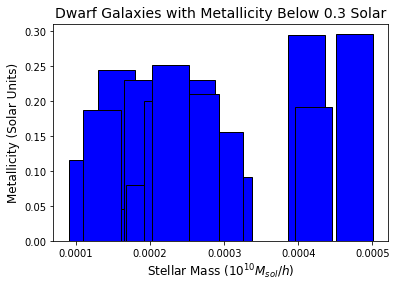

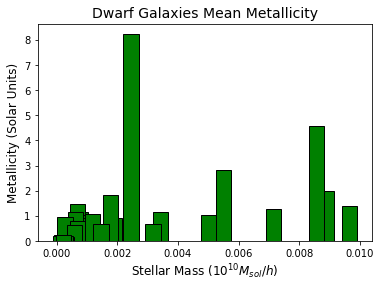

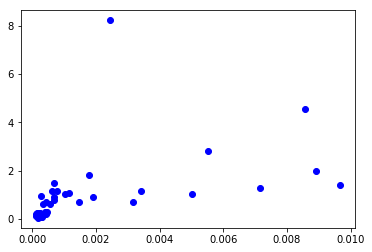

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1)
plt.bar(stellarmasscut,Z_cut,0.00005,color='blue',edgecolor='black')
plt.title('Dwarf Galaxies with Metallicity Below 0.3 Solar',fontsize=14)
plt.xlabel(r'Stellar Mass ($10^{10} M_{sol}/h$)',fontsize = 12)
plt.ylabel('Metallicity (Solar Units)',fontsize = 12)

plt.figure(2)
plt.bar(stellarmass,Z_dwarf,0.0005,color='green',edgecolor='black')
plt.title('Dwarf Galaxies Mean Metallicity',fontsize=14)
plt.xlabel(r'Stellar Mass ($10^{10} M_{sol}/h$)',fontsize = 12)
plt.ylabel('Metallicity (Solar Units)',fontsize = 12)

plt.figure(3)
plt.plot(stellarmass, Z_dwarf, 'bo')


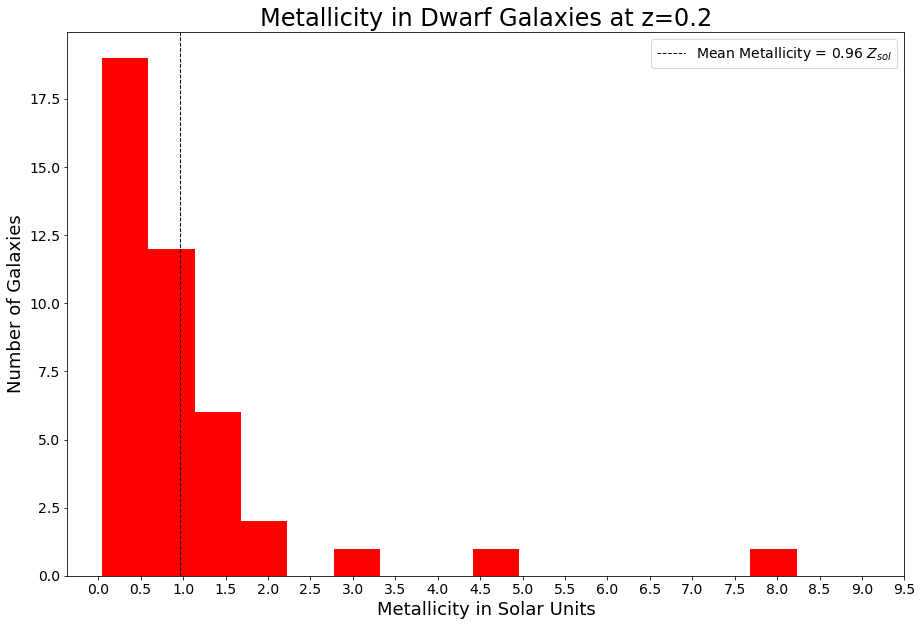

In [20]:
plt.figure(figsize=(15,10))
plt.hist(Z_dwarf,color='red',bins=15)
plt.title('Metallicity in Dwarf Galaxies at z=0.2',fontsize = 24)
plt.xlabel('Metallicity in Solar Units',fontsize=18)
plt.xticks(numpy.arange(0,10,0.5),fontsize=14)
plt.axvline(x=0.9639030860476192,linewidth=1, color='k', linestyle='--',label='Mean Metallicity = 0.96 $Z_{sol}$')
plt.yticks(fontsize=14)
#plt.xlim(xmin=0,xmax=1)
plt.ylabel('Number of Galaxies',fontsize=18)
plt.legend(fontsize=14)

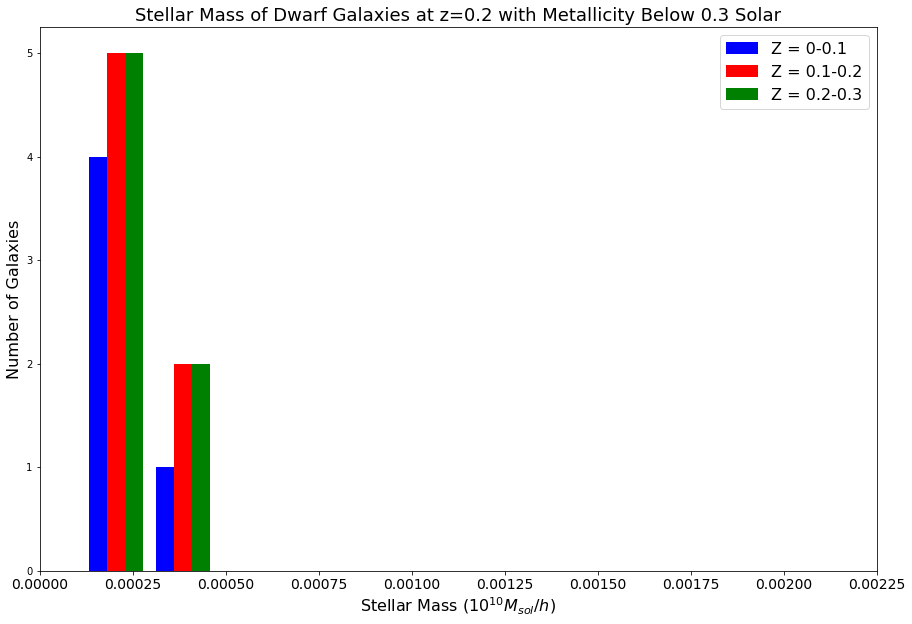

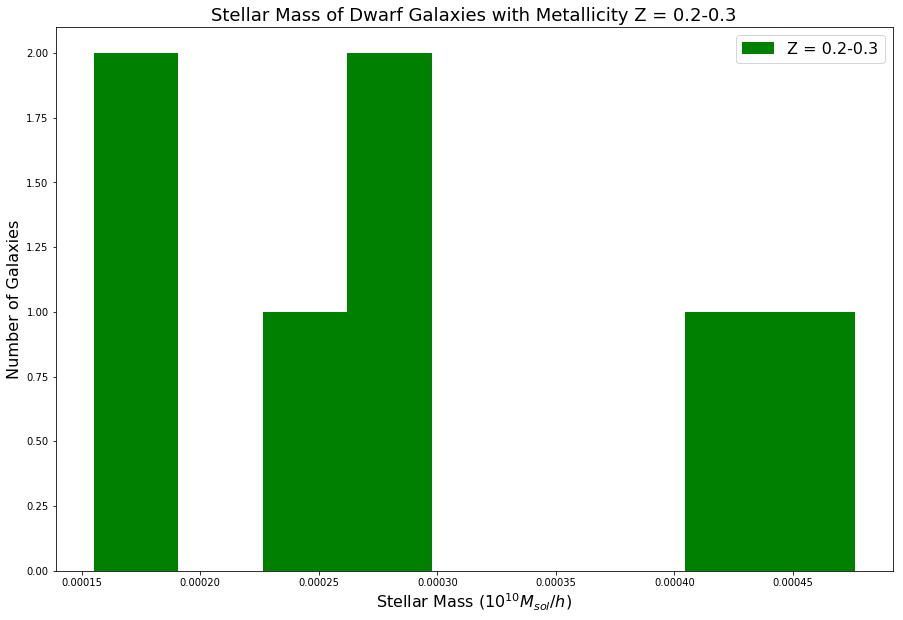

In [21]:
Z_0_1 = []
Z_1_2 = []
Z_2_3 = []
entry01 = []
entry12 = []
entry23 = []

for i in range(0,len(Z_dwarf)):
    if Z_dwarf[i]>=0 and Z_dwarf[i]<=0.1:
        Z_0_1.append(Z_dwarf[i])
        entry01.append(i)
    if Z_dwarf[i]>=0.1 and Z_dwarf[i]<=0.2:
        Z_1_2.append(Z_dwarf[i])
        entry12.append(i)
    if Z_dwarf[i]>=0.2 and Z_dwarf[i]<=0.3:
        Z_2_3.append(Z_dwarf[i])
        entry23.append(i)
        
        
stellarmass01 = []
stellarmass12 = []
stellarmass23 = []

for j in entry01:
    stellarmass01.append(stellarmass[j])
for k in entry12:
    stellarmass12.append(stellarmass[k])
for l in entry23:
    stellarmass23.append(stellarmass[l])
    

colors = ['blue', 'red', 'green']
names = ['Z = 0-0.1', 'Z = 0.1-0.2', 'Z = 0.2-0.3']
   
plt.figure(figsize=(15,10))
plt.hist([stellarmass01, stellarmass12, stellarmass23], bins = 2, color = colors, label=names)
plt.xticks(numpy.arange(0,0.0025,0.00025),fontsize=14)
#plt.yticks(numpy.arange(0,10,1),fontsize=14)
plt.title('Stellar Mass of Dwarf Galaxies at z=0.2 with Metallicity Below 0.3 Solar',fontsize=18)
plt.xlabel(r'Stellar Mass ($10^{10} M_{sol}/h$)',fontsize = 16)
plt.ylabel('Number of Galaxies',fontsize = 16)
plt.legend(prop={'size': 16})

# plt.figure(figsize=(15,10))
# plt.hist(stellarmass01, bins = 11, color = colors[0], label=names[0])
# #plt.xticks(numpy.arange(0,0.1,0.025),fontsize=14)
# #plt.yticks(numpy.arange(0,6,1),fontsize=14)
# plt.title('Stellar Mass of Dwarf Galaxies with Metallicity Z = 0-0.1',fontsize=18)
# plt.xlabel(r'Stellar Mass ($10^{10} M_{sol}/h$)',fontsize = 16)
# plt.ylabel('Number of Galaxies',fontsize = 16)
# plt.legend(prop={'size': 16})

# plt.figure(figsize=(15,10))
# plt.hist(stellarmass12, bins = 7, color = colors[1], label=names[1])
# #plt.xticks(numpy.arange(0.1,0.2,0.025),fontsize=14)
# #plt.yticks(numpy.arange(0,10,1),fontsize=14)
# plt.title('Stellar Mass of Dwarf Galaxies with Metallicity Z = 0.1-0.2',fontsize=18)
# plt.xlabel(r'Stellar Mass ($10^{10} M_{sol}/h$)',fontsize = 16)
# plt.ylabel('Number of Galaxies',fontsize = 16)
# plt.legend(prop={'size': 16})

plt.figure(figsize=(15,10))
plt.hist(stellarmass23, bins = 9, color = colors[2], label=names[2])
#plt.xticks(numpy.arange(0.2,0.3,0.025),fontsize=14)
#plt.yticks(numpy.arange(0,8,1),fontsize=14)
plt.title('Stellar Mass of Dwarf Galaxies with Metallicity Z = 0.2-0.3',fontsize=18)
plt.xlabel(r'Stellar Mass ($10^{10} M_{sol}/h$)',fontsize = 16)
plt.ylabel('Number of Galaxies',fontsize = 16)
plt.legend(prop={'size': 16})

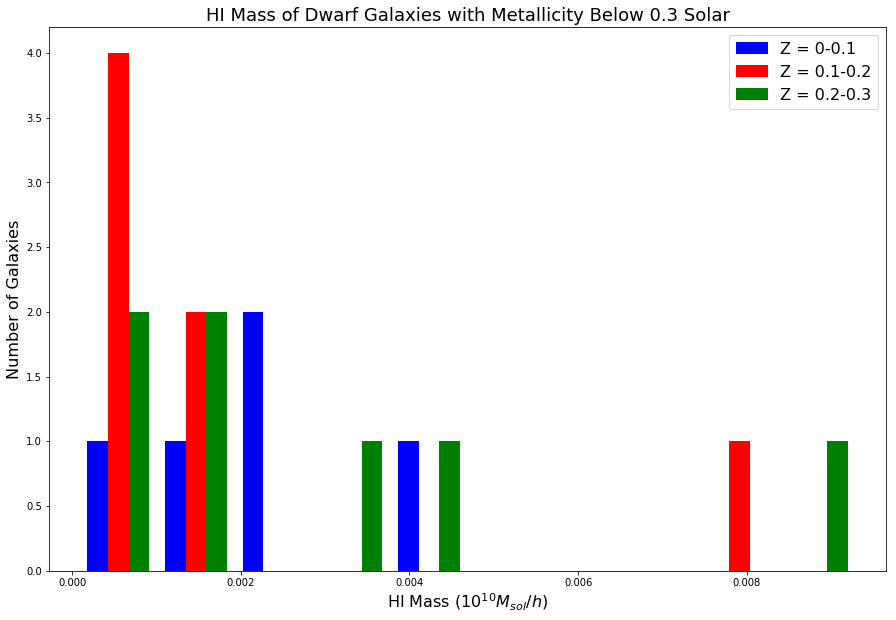

In [22]:
adjusted_HI_mass = []
for i in entry:
    adjusted_HI_mass.append(hi_mass[i])

HImass01 = []
HImass12 = []
HImass23 = []


for j in entry01:
    HImass01.append(hi_mass[j])
for k in entry12:
    HImass12.append(hi_mass[k])
for l in entry23:
    HImass23.append(hi_mass[l])

#print(HImass01)
colors = ['blue', 'red', 'green']
names = ['Z = 0-0.1', 'Z = 0.1-0.2', 'Z = 0.2-0.3']
   
plt.figure(figsize=(15,10))
plt.hist([HImass01, HImass12, HImass23], bins = 10, color = colors, label=names)
#plt.xticks(numpy.arange(0,0.35,0.025),fontsize=14)
plt.title('HI Mass of Dwarf Galaxies with Metallicity Below 0.3 Solar',fontsize=18)
plt.xlabel(r'HI Mass ($10^{10} M_{sol}/h$)',fontsize = 16)
plt.ylabel('Number of Galaxies',fontsize = 16)
plt.legend(prop={'size': 16})

In [23]:
def phistar(z) :
    phi0 = 0.0035
    phi1 = -2.2
    return phi0*(1+z)**phi1

def fracM(M, z) :
    M0 = 11.16
    M1 = 0.17
    M2 = -0.07

    hatM = 1e1**(M0 + M1*z + M2*z*z)
    return M/hatM

def phi(M,z=0.) :
    alpha0 = -1.18
    alpha1 = -0.082
    alpha = alpha0 + alpha1*z
    return math.log(10.) * phistar(z)*fracM(M,z)**(1.+alpha) * numpy.exp( -fracM(M,z))

def PanterZ(lgMstar) :

    logMc = 9.66
    Delta = 1.04
    A = -0.452
    B = 0.572
    out = numpy.tanh((lgMstar - logMc)/Delta)
    arg = A + B*out
    return 10**arg

def lamfit(Ptless,Zint):
# will return interpolated fit for lambda (fitting to O17 and Lamberts et al. 2016) given Z_HI or Z_dwarf (Zint) -- 
    Z = numpy.arange(0.001,1.,0.01)
    a = 3.9007870e-09
    b = 1.4792985e-07
    lamfit = a*((1./Z)**3) +b
    lamfit = lamfit/Ptless
    int = numpy.interp(Zint,Z,lamfit)
    ## now impose floor:
    lamint = numpy.minimum(int,1.5e-4*1.e1)
    print ("lamint=" + str(lamint))
    return lamint

def Richlambda(Zint):
# will read in file form Richard and return interpolated lambda values at Zint    
    #filename = "dat_lambda_factor.txt"  # old file don't use                     
    filename = "dat_lambda_M40cut.txt" # should have mass cut > 40 Msun           
    #filename = "dat_lambda.txt" # new file but doesn't have mass cut      

    data = loadtxt(filename,
              dtype=([('Z', 'float'), ('lambda', 'float'), ('av_mc', 'float'), ('V', 'float')]))

    lam = data["lambda"]/1.e-3
    Z = data["Z"]/0.0134

    lamint = numpy.interp(Zint,Z,lam)
    print ("lamint=" + str(lamint))
    return lamint

def TremontiZ(lgMstar, corr = 0.):
    lgZ = -1.492 + 1.847*lgMstar - 0.08026*(lgMstar**2) - 8.69 +corr
    return 10**lgZ

def AM13Z(lgMstar,OHasym,Mto,gamma):
    Mstar = 10**lgMstar
    lgZ = OHasym - numpy.log10(1.+(Mto/Mstar)**gamma) - 8.69
    return 10**lgZ

def LeeZ(lgMstar):
    lgZ = 5.65 + 0.298*lgMstar - 8.66
    return 10**lgZ

def mratedwarfZLee(Mstar,SFRdwarf,Zdwarf,Ptless,dt,ZLee,dlgM,Mhdwarf,Phi_dwarf):
    #lmbda = lamfit(Ptless,Zdwarf)
    lmbda = Richlambda(Zdwarf)
    Ndwarf = SFRdwarf*(1./Zdwarf)*lmbda*Ptless*dt
    #print "N_dwarf = " + str(Ndwarf)                                          
    return (Zdwarf*Phi_dwarf*dlgM*(Mstar/Mhdwarf)*Ndwarf).sum()


def mratedwarfZP(Mstar,SFRdwarf,Zdwarf,Ptless,dt,Zp,dlgM,Mhdwarf,Phi_dwarf) :

#    lmbda = lamfit(Ptless,Zp) # leads to weird plot
    lmbda = Richlambda(Zdwarf)
#    lmbda = lamfit(Ptless,Zdwarf)

    Ndwarf = SFRdwarf*(1./Zdwarf)*lmbda*Ptless*dt
    #print "N_dwarf = " + str(Ndwarf)
    return (Zdwarf*Phi_dwarf*dlgM*(Mstar/Mhdwarf)*Ndwarf).sum()

def mratedwarfZAM13(Mstar,SFRdwarf,Zdwarf,Ptless,dt,ZAM13,dlgM,Mhdwarf,Phi_dwarf) :

#    lmbda = lamfit(Ptless,ZAM13)
    lmbda = Richlambda(Zdwarf)
#    lmbda = lamfit(Ptless,Zdwarf)

    Ndwarf = SFRdwarf*(1./Zdwarf)*lmbda*Ptless*dt
    #print "N_dwarf = " + str(Ndwarf)
    return (Zdwarf*Phi_dwarf*dlgM*(Mstar/Mhdwarf)*Ndwarf).sum()

def mratedwarfZTrem(Mstar,SFRdwarf,Zdwarf,Ptless,dt,ZTrem,dlgM,Mhdwarf,Phi_dwarf) :

#    lmbda = lamfit(Ptless,ZTrem)
    lmbda = Richlambda(Zdwarf)
#    lmbda = lamfit(Ptless,Zdwarf)

    Ndwarf = SFRdwarf*(1./Zdwarf)*lmbda*Ptless*dt
    #print "N_dwarf = " + str(Ndwarf)
    return (Zdwarf*Phi_dwarf*dlgM*(Mstar/Mhdwarf)*Ndwarf).sum()

def mratedwarfZdwarf(Mstar,SFRdwarf,Zdwarf,Ptless,dt,dlgM,Mhdwarf,Phi_dwarf) :

#    lmbda = lamfit(Ptless,Zdwarf)
    lmbda = Richlambda(Zdwarf)
#    lmbda = lamfit(Ptless,Zdwarf)

    Ndwarf = SFRdwarf*(1./Zdwarf)*lmbda*Ptless*dt
    #print "N_dwarf = " + str(Ndwarf)
    return (Zdwarf*Phi_dwarf*dlgM*(Mstar/Mhdwarf)*Ndwarf).sum(),lmbda

def detectrdwarfZp(Mstar,SFRdwarf,Zdwarf,Ptless,dt,Zp,dlgM,Mhdwarf,Phi_dwarf) :

#    lmbda = lamfit(Ptless,Zp)
    lmbda = Richlambda(Zdwarf)
#    lmbda = lamfit(Ptless,Zdwarf)

    Ndwarf = SFRdwarf*(1./Zdwarf)*lmbda*Ptless*dt
    return ((Zdwarf/Zp)*Phi_dwarf*dlgM*(Mstar/Mhdwarf)*Ndwarf)

def detectrdwarfZdwarf(Mstar,SFRdwarf,Zdwarf,Ptless,dt,dlgM,Mhdwarf,Phi_dwarf) :

#    lmbda = lamfit(Ptless,Zdwarf)
    lmbda = Richlambda(Zdwarf)
#    lmbda = lamfit(Ptless,Zdwarf)

    Ndwarf = SFRdwarf*(1./Zdwarf)*lmbda*Ptless*dt
    return ((Zdwarf/Zdwarf)*Phi_dwarf*dlgM*(Mstar/Mhdwarf)*Ndwarf)

def detectrdwarfZAm13(Mstar,SFRdwarf,Zdwarf,Ptless,dt,ZAM13,dlgM,Mhdwarf,Phi_dwarf) :

#    lmbda = lamfit(Ptless,ZAM13)
    lmbda = Richlambda(Zdwarf)
#    lmbda = lamfit(Ptless,Zdwarf)

    Ndwarf = SFRdwarf*(1./Zdwarf)*lmbda*Ptless*dt
    return ((Zdwarf/ZAM13)*Phi_dwarf*dlgM*(Mstar/Mhdwarf)*Ndwarf)

def detectrdwarfZTrem(Mstar,SFRdwarf,Zdwarf,Ptless,dt,ZTrem,dlgM,Mhdwarf,Phi_dwarf) :

#    lmbda = lamfit(Ptless,ZTrem)
    lmbda = Richlambda(Zdwarf)
#    lmbda = lamfit(Ptless,Zdwarf)

    Ndwarf = SFRdwarf*(1./Zdwarf)*lmbda*Ptless*dt
    return ((Zdwarf/ZTrem)*Phi_dwarf*dlgM*(Mstar/Mhdwarf)*Ndwarf)

def detectrdwarfZLee(Mstar,SFRdwarf,Zdwarf,Ptless,dt,ZLee,dlgM,Mhdwarf,Phi_dwarf) :
#    lmbda = lamfit(Ptless,ZLee)
    lmbda = Richlambda(Zdwarf)
#    lmbda = lamfit(Ptless,Zdwarf)

    Ndwarf = SFRdwarf*(1./Zdwarf)*lmbda*Ptless*dt
    return ((Zdwarf/ZLee)*Phi_dwarf*dlgM*(Mstar/Mhdwarf)*Ndwarf)


In [24]:
####--------Set parameters and return merger rate, detection rate, and plots --------

ZHI = 0.35
print ("Z_HI=" + str(ZHI))

M51 = 3.98e10  ## from Leroy et al. 2008                                        

SFRM51 = 0.1 ## Bigiel et al. 2010, C11
ZM51 = 0.1  # C11
dt = 10.e9  # Bigiel et al. 2010 - depletion time
                                                 
Ptless = 1.e-3  # the fraction of black holes that merge within Hubble time

dlgM = 0.1
lgMstar = numpy.arange(5, 9.89, dlgM)
Mstar =1e1**lgMstar

Phi_dwarf = phi(Mstar,z=0)
print(Phi_dwarf)
ZTrem = TremontiZ(lgMstar,corr=-0.26)
ZPanter = PanterZ(lgMstar)
ZLee = LeeZ(lgMstar)

## from Andrews & Martini 2013:
#Mto = 10**32.65
#OHasym = 16.988
#gamma = 0.373
### first row for MZR in Table 4:
#Mto = 10**8.901
#OHasym = 8.798
#gamma = 0.64
### second row:
Mto = 8.253
OHasym = 8.726
gamma = 0.734
ZAM13 = AM13Z(lgMstar,OHasym,Mto,gamma)

###----------dwarf galaxy parameters ---------------

print ("------dwarfs---------")

Mhdwarf = 2.5e8  ## from O17 h516
SFRdwarf = 0.01
Zdwarf = 0.1
## the bigger one h603
# Mhdwarf = 7.8e9
# SFRdwarf = 1.
# Zdwarf = 0.4

Z_HI=0.35
[0.1035341  0.09933067 0.09529788 0.09142882 0.08771684 0.08415555
 0.08073885 0.07746084 0.07431592 0.07129866 0.06840388 0.06562661
 0.06296207 0.06040567 0.05795304 0.05559993 0.0533423  0.05117628
 0.04909811 0.04710423 0.04519118 0.04335567 0.04159452 0.03990468
 0.0382832  0.03672728 0.03523418 0.03380128 0.03242606 0.03110606
 0.02983893 0.02862236 0.02745412 0.02633202 0.02525393 0.02421774
 0.02322136 0.0222627  0.02133968 0.02045018 0.01959202 0.01876295
 0.01796064 0.0171826  0.01642618 0.01568854 0.01496657 0.0142569
 0.01355583]
------dwarfs---------


In [25]:
StellarMass = []
converted_stellar_mass = []
HImass = []
VirialMass = []
Metallicity = []
StarFormation= []
HaloID = []
LHAT = []

for i in range(1,len(all_data)):
    StellarMass.append(all_data[i][1])
    converted_stellar_mass.append(all_data[i][1]*1e10*0.704)
    HImass.append(all_data[i][5])
    VirialMass.append(all_data[i][3])
    Metallicity.append(all_data[i][7])
    StarFormation.append(all_data[i][8])
    HaloID.append(all_data[i][0])
    LHAT.append(all_data[i][6])
    
print(numpy.mean(StarFormation))
print(converted_stellar_mass[-1])
print(StarFormation[-1])
print(Metallicity[-1])

0.006208638755
1605120.0
0.0033337642
0.2514321


In [26]:
MratedwarfZP= mratedwarfZP(Mstar,1,Metallicity[0],Ptless,dt,ZPanter,dlgM,converted_stellar_mass[0],Phi_dwarf)
print(MratedwarfZP)
MratedwarfZP1= mratedwarfZP(Mstar,10,Metallicity[0],Ptless,dt,ZPanter,dlgM,converted_stellar_mass[0],Phi_dwarf)
print(MratedwarfZP1)

lamint=0.0
0.0
lamint=0.0
0.0


In [27]:
# This loops over all galaxies in the all_data array and calculates the merger rates and detection rates below
# It stores the merger rate and detection rate of Zdwarf as well as lambda into an array

MRATEDDWARFZDWARF = []
DRATEDDWARFZDWARF = []
DRATEDDWARFZLEE = []
DRATEDDWARFZP = []
DRATEDDWARFZAM13 = []
DRATEDDWARFZTREM = []
LAMBDA = []

for i in range(0,len(Metallicity)):
    
    print('---------------------------------HALO  '+str(HaloID[i])+'----------------------------------------')

    MratedwarfZP= mratedwarfZP(Mstar,StarFormation[i],Metallicity[i],Ptless,dt,ZPanter,dlgM,converted_stellar_mass[i],Phi_dwarf)
    print ("merger rate dwarfs per cubic Gpc w Panter = " + str(MratedwarfZP*1e3**3/dt)) # conversion to Gpc-3 and rate                                                                  
    print('')
    #MRATEDDWARFZP.append(MratedwarfZP*1e3**3/dt)
    
    MratedwarfZAM13= mratedwarfZAM13(Mstar,StarFormation[i],Metallicity[i],Ptless,dt,ZAM13,dlgM,converted_stellar_mass[i],Phi_dwarf)
    print ("merger rate dwarfs per cubic Gpc w AM13 = " + str(MratedwarfZAM13*1e3**3/dt)) 
    print('')
    
    MratedwarfZTrem= mratedwarfZTrem(Mstar,StarFormation[i],Metallicity[i],Ptless,dt,ZTrem,dlgM,converted_stellar_mass[i],Phi_dwarf)
    print ("merger rate dwarfs per cubic Gpc w Tremonti = " + str(MratedwarfZTrem*1e3**3/dt))
    print('')
    
    DratedwarfZP = detectrdwarfZp(Mstar,StarFormation[i],Metallicity[i],Ptless,dt,ZPanter,dlgM,converted_stellar_mass[i],Phi_dwarf)
    print ("detection rate dwarfs per cubic Gpc with Panter = " + str(DratedwarfZP.sum()*1e3**3/dt))
    print('')
    DRATEDDWARFZP.append(DratedwarfZP.sum()*1e3**3/dt)
    
    MratedwarfZdwarf, Lambda = mratedwarfZdwarf(Mstar,StarFormation[i],Metallicity[i],Ptless,dt,dlgM,converted_stellar_mass[i],Phi_dwarf)
    print ("merger rate dwarfs per cubic Gpc w Zdwarf = " + str(MratedwarfZdwarf*1e3**3/dt)) 
    print('')
    MRATEDDWARFZDWARF.append(MratedwarfZdwarf*1e3**3/dt)
    LAMBDA.append(Lambda)
    
    
    DratedwarfZdwarf = detectrdwarfZdwarf(Mstar,StarFormation[i],Metallicity[i],Ptless,dt,dlgM,converted_stellar_mass[i],Phi_dwarf)
    print ("detection rate dwarfs per cubic Gpc with Zdwarf = " + str(DratedwarfZdwarf.sum()*1e3**3/dt))
    print('')
    DRATEDDWARFZDWARF.append(DratedwarfZdwarf.sum()*1e3**3/dt)
    
    DratedwarfZAM13 = detectrdwarfZAm13(Mstar,StarFormation[i],Metallicity[i],Ptless,dt,ZAM13,dlgM,converted_stellar_mass[i],Phi_dwarf)
    print ("detection rate dwarfs per cubic Gpc with AM13 = " + str(DratedwarfZAM13.sum()*1e3**3/dt))
    print('')
    DRATEDDWARFZAM13.append(DratedwarfZAM13.sum()*1e3**3/dt)
    
    DratedwarfZTrem = detectrdwarfZTrem(Mstar,StarFormation[i],Metallicity[i],Ptless,dt,ZTrem,dlgM,converted_stellar_mass[i],Phi_dwarf)
    print ("detection rate dwarfs per cubic Gpc with Tremonti = " + str(DratedwarfZTrem.sum()*1e3**3/dt))
    print('')
    DRATEDDWARFZTREM.append(DratedwarfZTrem.sum()*1e3**3/dt)
    
    DratedwarfZLee = detectrdwarfZLee(Mstar,StarFormation[i],Metallicity[i],Ptless,dt,ZLee,dlgM,converted_stellar_mass[i],Phi_dwarf)
    print ("detection rate dwarfs per cubic Gpc with Lee = " + str(DratedwarfZLee.sum()*1e3**3/dt))
    DRATEDDWARFZLEE.append(DratedwarfZLee.sum()*1e3**3/dt)
    print('')
    print('')
    print('')
    print('')
    
    

---------------------------------HALO  256160----------------------------------------
lamint=0.0
merger rate dwarfs per cubic Gpc w Panter = 0.0

lamint=0.0
merger rate dwarfs per cubic Gpc w AM13 = 0.0

lamint=0.0
merger rate dwarfs per cubic Gpc w Tremonti = 0.0

lamint=0.0
detection rate dwarfs per cubic Gpc with Panter = 0.0

lamint=0.0
merger rate dwarfs per cubic Gpc w Zdwarf = 0.0

lamint=0.0
detection rate dwarfs per cubic Gpc with Zdwarf = 0.0

lamint=0.0
detection rate dwarfs per cubic Gpc with AM13 = 0.0

lamint=0.0
detection rate dwarfs per cubic Gpc with Tremonti = 0.0

lamint=0.0
detection rate dwarfs per cubic Gpc with Lee = 0.0




---------------------------------HALO  273994----------------------------------------
lamint=0.0
merger rate dwarfs per cubic Gpc w Panter = 0.0

lamint=0.0
merger rate dwarfs per cubic Gpc w AM13 = 0.0

lamint=0.0
merger rate dwarfs per cubic Gpc w Tremonti = 0.0

lamint=0.0
detection rate dwarfs per cubic Gpc with Panter = 0.0

lamint=0.0
m

lamint=0.0003249325755768308
detection rate dwarfs per cubic Gpc with AM13 = 65.14130893369756

lamint=0.0003249325755768308
detection rate dwarfs per cubic Gpc with Tremonti = 174.76302606965228

lamint=0.0003249325755768308
detection rate dwarfs per cubic Gpc with Lee = 132.48528674328134




---------------------------------HALO  412708----------------------------------------
lamint=0.00042527986864153
merger rate dwarfs per cubic Gpc w Panter = 6.8154002504198665

lamint=0.00042527986864153
merger rate dwarfs per cubic Gpc w AM13 = 6.8154002504198665

lamint=0.00042527986864153
merger rate dwarfs per cubic Gpc w Tremonti = 6.8154002504198665

lamint=0.00042527986864153
detection rate dwarfs per cubic Gpc with Panter = 29.58917285947709

lamint=0.00042527986864153
merger rate dwarfs per cubic Gpc w Zdwarf = 6.8154002504198665

lamint=0.00042527986864153
detection rate dwarfs per cubic Gpc with Zdwarf = 146.31611506877027

lamint=0.00042527986864153
detection rate dwarfs per cubic Gp

lamint=0.00043290772951431686
merger rate dwarfs per cubic Gpc w Tremonti = 4.35178053919204

lamint=0.00043290772951431686
detection rate dwarfs per cubic Gpc with Panter = 18.893327154590672

lamint=0.00043290772951431686
merger rate dwarfs per cubic Gpc w Zdwarf = 4.35178053919204

lamint=0.00043290772951431686
detection rate dwarfs per cubic Gpc with Zdwarf = 47.173639827053506

lamint=0.00043290772951431686
detection rate dwarfs per cubic Gpc with AM13 = 4.005601224418966

lamint=0.00043290772951431686
detection rate dwarfs per cubic Gpc with Tremonti = 10.74634517891361

lamint=0.00043290772951431686
detection rate dwarfs per cubic Gpc with Lee = 8.14664665913496




---------------------------------HALO  517303----------------------------------------
lamint=1.2196207370491706e-06
merger rate dwarfs per cubic Gpc w Panter = 0.06183189686876837

lamint=1.2196207370491706e-06
merger rate dwarfs per cubic Gpc w AM13 = 0.06183189686876837

lamint=1.2196207370491706e-06
merger rate dw

In [28]:
print(LAMBDA)

[0.0, 0.0, 5.173807938797817e-06, 0.0003546605037683064, 0.0, 4.59731106010928e-07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003075079751420768, 0.0, 0.00034459382391694034, 1.8914302789071009e-06, 0.0003375746557457927, 0.0, 0.0, 0.0, 0.0003074552599521314, 0.0004045602614529396, 0.0003249325755768308, 0.00042527986864153, 0.0, 0.0, 0.0, 0.0003374620441228419, 0.00034371584699453595, 5.6683658063388e-06, 0.0004588378344045903, 0.0, 0.0004113098102067757, 0.0, 0.00041214054342644785, 0.00043290772951431686, 1.2196207370491706e-06, 0.00034371584699453595, 0.00034371584699453595, 0.00037752944403497284, 0.0, 0.00034371584699453595, 0.00031833654666010944]


In [582]:
with open("dwarf_merger_rate_z=0.2.txt", "w") as myfile:
    for i in range(0,len(Metallicity)):
        ids = HaloID[i],VirialMass[i],StellarMass[i],HImass[i], Metallicity[i], StarFormation[i], LAMBDA[i], MRATEDDWARFZDWARF[i], DRATEDDWARFZDWARF[i]
        myfile.write(str(ids)+'\n')

In [29]:
# This finds the merger rate and detection rate of galaxies that have metallicities below 0.3 solar
# It creates arrays for the merger rate, detection rate, and index value that these galaxies reside in

merger_rate_lowz = []
detection_rate_lowz = []
detect_LEE = []
detect_ZP = []
detect_ZAM13 = []
detect_Ztrem = []
sfr_lowz = []
entry2 = []

for i in range(0,len(MRATEDDWARFZDWARF)):
    if Metallicity[i]<=0.3:
        merger_rate_lowz.append(MRATEDDWARFZDWARF[i])
        detection_rate_lowz.append(DRATEDDWARFZDWARF[i])
        detect_LEE.append(DRATEDDWARFZLEE[i])
        detect_ZP.append(DRATEDDWARFZP[i])
        detect_ZAM13.append(DRATEDDWARFZAM13[i])
        detect_Ztrem.append(DRATEDDWARFZTREM[i])
        sfr_lowz.append(StarFormation[i])
        entry2.append(i)

newHaloID = []
newVirialMass = []
newStellarMass = []
newHImass = []
newMetallicity = []
newStarFormation = []
newMRATEDDWARFZDWARF = []
newDRATEDDWARFZDWARF = []
newLAMBDA = []

HaloID = numpy.array(HaloID)
VirialMass = numpy.array(VirialMass)
StellarMass = numpy.array(StellarMass)
HImass = numpy.array(HImass)
Metallicity = numpy.array(Metallicity)
StarFormation = numpy.array(StarFormation)
MRATEDDWARFZDWARF = numpy.array(MRATEDDWARFZDWARF)
DRATEDDWARFZDWARF = numpy.array(DRATEDDWARFZDWARF)
LAMBDA = numpy.array(LAMBDA)

# This loops over the indices that include galaxies with metallicities below 0.3 solar and extracts the following information and stores them into new arrays
for i in entry2:
    newHaloID.append(HaloID[i])
    newVirialMass.append(VirialMass[i])
    newStellarMass.append(StellarMass[i])
    newHImass.append(HImass[i])
    newMetallicity.append(Metallicity[i])
    newStarFormation.append(StarFormation[i])
    newMRATEDDWARFZDWARF.append(MRATEDDWARFZDWARF[i]) 
    newDRATEDDWARFZDWARF.append(DRATEDDWARFZDWARF[i])
    newLAMBDA.append(LAMBDA[i])
    
    
#print(newHaloID)
    
print(numpy.max(detection_rate_lowz))
        
print(numpy.mean(merger_rate_lowz))
print('')
print(numpy.mean(detection_rate_lowz))
print('')
print('Zdwarf :',numpy.sum(detection_rate_lowz))
print('')
print('Lee: ',numpy.sum(detect_LEE))
print('')
print('ZP: ', numpy.sum(detect_ZP))
print('')
print('ZAM13: ',numpy.sum(detect_ZAM13))
print('')
print('Ztrem: ', numpy.sum(detect_Ztrem))
print(numpy.mean(sfr_lowz))
    
    


289.72296471104863
18.522093030572762

115.27728469466801

Zdwarf : 2190.268409198692

Lee:  658.802982601378

ZP:  1527.865488894249

ZAM13:  323.92494042931196

Ztrem:  869.0353899163673
0.0016256840131578948


In [ ]:
for i in range(0,len(LHAT)):
    metallicity_plot('cutout_'+str(HaloID[i])+'.hdf5',LHAT[i]) 

In [ ]:
# Illustris

from numpy import mean, size, zeros, where, transpose
from scipy import linspace
from matplotlib.pyplot import hist

log_mstar = []
    
for j in converted_stellar_mass:
    LOG_mstar = numpy.log10(j)
    log_mstar.append(LOG_mstar)
    
mu = numpy.mean(converted_stellar_mass)
sigma = numpy.std(converted_stellar_mass)

x = converted_stellar_mass

x_max = max(x)
x_min = min(x)
N_MIN = 4   #Minimum number of bins (integer)
            #N_MIN must be more than 1 (N_MIN > 1).
N_MAX = 50  #Maximum number of bins (integer)
N = range(N_MIN,N_MAX) # #of Bins
N = numpy.array(N)
D = (x_max-x_min)/N    #Bin size vector
C = numpy.zeros(shape=(size(D),1))

#Computation of the cost function
for i in range(size(N)):
    edges = linspace(x_min,x_max,N[i]+1) # Bin edges
    ki = hist(x,edges) # Count # of events in bins
    ki = ki[0]    
    k = mean(ki) #Mean of event count
    v = sum((ki-k)**2)/N[i] #Variance of event count
    C[i] = (2*k-v)/((D[i])**2) #The cost Function

#Optimal Bin Size Selection

cmin = min(C)
idx  = where(C==cmin)
idx = int(idx[0])
optD = D[idx]

edges = linspace(x_min,x_max,N[idx]+1)
fig = plt.figure(3)

fig, ax = plt.subplots()

# Histogram
n, bins, patches = ax.hist(x,edges)

# Best fit line
# y = mlab.normpdf(bins, mu, sigma)
# ax.plot(bins, y, '--')
ax.set_xlabel('Stellar Masses')
ax.set_ylabel('Number of Galaxies')
plt.title("Illustris Stellar Mass Distribution (Initial Mass Cuts) ($10^{10} M_{sol}/h$)")
print("The mean is:",mu,'and the standard deviation is:',sigma)

In [ ]:
mu = numpy.mean(log_mstar)
sigma = numpy.std(log_mstar)

x = log_mstar

x_max = max(x)
x_min = min(x)
N_MIN = 4   #Minimum number of bins (integer)
            #N_MIN must be more than 1 (N_MIN > 1).
N_MAX = 50  #Maximum number of bins (integer)
N = range(N_MIN,N_MAX) # #of Bins
N = numpy.array(N)
D = (x_max-x_min)/N    #Bin size vector
C = numpy.zeros(shape=(size(D),1))

#Computation of the cost function
for i in range(size(N)):
    edges = linspace(x_min,x_max,N[i]+1) # Bin edges
    ki = hist(x,edges) # Count # of events in bins
    ki = ki[0]    
    k = mean(ki) #Mean of event count
    v = sum((ki-k)**2)/N[i] #Variance of event count
    C[i] = (2*k-v)/((D[i])**2) #The cost Function

#Optimal Bin Size Selection

cmin = min(C)
idx  = where(C==cmin)
idx = int(idx[0])
optD = D[idx]

edges = linspace(x_min,x_max,N[idx]+1)
fig = plt.figure(3)

fig, ax = plt.subplots()

# Histogram
n, bins, patches = ax.hist(x,edges)

# Best fit line
# y = mlab.normpdf(bins, mu, sigma)
# ax.plot(bins, y, '--')
ax.set_xlabel(r'$Log(M_{HI}/M_{sol})$')
ax.set_ylabel('Number of Galaxies')
#plt.xlim(6,12)
plt.title("Log Illustris Stellar Mass Distribution (Initial Mass Cuts)")
print("The mean is:",mu,'and the standard deviation is:',sigma)

In [ ]:
def phi(M,h):
    phistar = 4.8e-03/h**3
    Mstar = 10**(9.96 - 2.0*numpy.log10(h))
    alpha = -1.33
    phi = numpy.log(10)*phistar*((M/Mstar)**(alpha+1.))*numpy.exp(-M/Mstar)
    return phi # not converted yet

In [ ]:
# Illustris

converted_stellar_mass = numpy.array(converted_stellar_mass)
Phi_illustris = phi(converted_stellar_mass,0.704)
#print(Phi_illustris)

plt.plot(log_mstar,numpy.log10(Phi_illustris),'bo')
#plt.xlim(6,11)
#plt.ylim(-2.5,0)
plt.xlabel(r'$Log(M_{HI}/M_{sol})$')
plt.ylabel('Log(phi)')
plt.title('Illustris Stellar Mass Function')